In [55]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# from sklearn.feature_selection import SelectKBest, f_regression
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics  # For evaluation metrics
import xgboost as xgb  # pip install xgboost
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, learning_curve, validation_curve

from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from hyperopt.pyll.base import scope

In [56]:
# Load Data
# columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
#            'Central Air', 'Total Bsmt SF', 'SalePrice', 'Lot Area',
#            'Full Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF']

columns = [
    "Overall Qual",
    "Overall Cond",
    "Gr Liv Area",
    "Central Air",
    "Total Bsmt SF",
    "SalePrice",
]

df = pd.read_csv("AmesHousing.txt", sep="\t", usecols=columns)

In [57]:
# Pipeline for data cleaning -> train_test_split -> and Model Training
df["Central_Air_Binary"] = df["Central Air"].map({"N": 0, "Y": 1})
y = df["SalePrice"]
X = df.drop(["Central Air", "SalePrice"], axis=1)

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

pipelines = {
    "xgb": Pipeline([("scaler", MinMaxScaler()), ("xgb", xgb.XGBRegressor())]),
    "rf": Pipeline([("scaler", MinMaxScaler()), ("rf", RandomForestRegressor())]),
}


pipelines["xgb"].fit(X_train, y_train)
# pipelines['rf'].fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [58]:
# R2, MAE, MSE
y_pred = pipelines["xgb"].predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f"Model: XGB Regression")
print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R-squared: {r2:.2f}")
print("-----------------")

Model: XGB Regression
  MSE: 955592189.74
  MAE: 21407.60
  R-squared: 0.88
-----------------


In [59]:
# # R2, MAE, MSE
# y_pred = pipelines['rf'].predict(X_test)
# mse = metrics.mean_squared_error(y_test, y_pred)
# mae = metrics.mean_absolute_error(y_test, y_pred)
# r2 = metrics.r2_score(y_test, y_pred)
# print(f"Model: Random Forest Regressor")
# print(f"  MSE: {mse:.2f}")
# print(f"  MAE: {mae:.2f}")
# print(f"  R-squared: {r2:.2f}")
# print("-----------------")

In [60]:
# # Hyperparmeter tuning
# param_grid = {
#     'rgbr__n_estimators': [100, 150, 200, 250, 300, 350, 400],
#     'rgbr__max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'rgbr__learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
#     'rgbr__subsample': [0.6, 0.8, 1.0, 1.2],
#     'rgbr__colsample_bytree': [0.6, 0.8, 1.0, 1.2],
#     'rgbr__reg_alpha': [0.001, 0.01, 0.1, 1, 10, 100],
#  }

# # GridSearchCV
# grid_search = GridSearchCV(pipeline, param_grid, cv=10)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# # best_params = {'C': 0.5994842503189409, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

# pipeline = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('lr', xgb.XGBRegressor()(**best_params) )
# ])

In [61]:
from scipy.stats import randint, uniform

param_dist = {
    "xgb__n_estimators": randint(100, 400),
    "xgb__max_depth": randint(2, 8),
    "xgb__learning_rate": uniform(0.01, 0.2),
    "xgb__subsample": uniform(0.6, 0.4),
    "xgb__colsample_bytree": uniform(0.6, 0.4),
    "xgb__reg_alpha": uniform(0, 1),
}
random_search = RandomizedSearchCV(
    pipelines["xgb"],
    param_dist,
    n_iter=100,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           device=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           grow_policy=None,
                                                           importance_type...
                                        'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DDDA1E1C10>,
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DDEEAE4200>,
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DDEFBC1BB0>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DDEFBBEB70>},
                   scoring='neg_mean_squared_error', verbose=1)

In [62]:
# # from scipy.stats import randint, uniform
# param_dist = {
#             'rf__n_estimators': [10, 25, 50, 75, 100, 125, 150],
#             'rf__max_features': ['auto', 'sqrt'],
#             'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
#             'rf__min_samples_split': [2, 5, 10],
#             'rf__min_samples_leaf': [1, 2, 4],
#             'rf__bootstrap': [True, False]
# }

# random_search1 = RandomizedSearchCV(pipelines['rf'], param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', verbose=1)
# random_search1.fit(X_train, y_train)

In [63]:
# # Best model usage
# best_model1 = random_search1.best_estimator_
# predictions1 = best_model1.predict(X_test)
# mse = metrics.mean_squared_error(y_test, predictions1)
# mae = metrics.mean_absolute_error(y_test, predictions1)
# r2 = metrics.r2_score(y_test, predictions1)
# print(f"Model: Random Forest Regression\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nR-squared: {r2:.2f}\n-----------------")

In [64]:
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)
mse = metrics.mean_squared_error(y_test, predictions)
mae = metrics.mean_absolute_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)
print(
    f"Model: XGB Regression\nMSE: {mse:.2f}\nMAE: {mae:.2f}\nR-squared: {r2:.2f}\n-----------------"
)

Model: XGB Regression
MSE: 824377187.02
MAE: 19854.62
R-squared: 0.90
-----------------


In [74]:
print(random_search.best_estimator_)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8196235298606114, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.03186751598813972, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strateg

In [65]:
# # Learning Curve Plot xgb
# from sklearn.model_selection import learning_curve
# train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10))
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)
# plt.figure(figsize=(8, 5))
# plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
# plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
# plt.title("Learning Curve for XGB Regressor")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()

In [66]:
# # Learning Curve Plot random Forest
# from sklearn.model_selection import learning_curve
# train_sizes, train_scores, test_scores = learning_curve(best_model1, X_train, y_train, cv=5, n_jobs=3, train_sizes=np.linspace(0.1, 1.0, 10))
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)
# plt.figure(figsize=(8, 5))
# plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="r", alpha=0.1)
# plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="g", alpha=0.1)
# plt.title("Learning Curve for Random Forest Regressor")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()

In [67]:
# from sklearn.model_selection import validation_curve

# # Define the parameter name and range for the validation curve
# param_name = 'rf__max_depth'  # XGBoost's parameter for tree depth
# param_range = np.arange(1, 11)  # Exploring depths from 1 to 10

# # Generate the validation curve
# train_scores, test_scores = validation_curve(
#     best_model1,  # Ensure you use the best model from your hyperparameter tuning
#     X_train, y_train,
#     param_name=param_name,
#     param_range=param_range,
#     cv=10,
#     scoring="r2",  # You can change this to another scoring method depending on what you're interested in
#     n_jobs=-1  # Use all available cores
# )

# # Calculate means and standard deviations
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Plotting the validation curve
# plt.figure(figsize=(8, 5))
# plt.plot(param_range, train_mean, label='Training score', color='blue')
# plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
# plt.plot(param_range, test_mean, label='Cross-validation score', color='green')
# plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

# plt.title("Validation Curve with Random Forest Regressor")
# plt.xlabel("Max Depth")
# plt.ylabel("Score (R^2)")
# plt.legend(loc="best")
# plt.grid(True)
# plt.show()

In [68]:
# param_name = 'xgb__learning_rate'  # Choose a hyperparameter to vary
# param_range = np.logspace(-3, 2, num=5)

# train_scores, test_scores = validation_curve(
#     pipelines['xgb'], X_train, y_train, param_name=param_name, param_range=param_range, cv=10)

# # Calculate means and standard deviations
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# # Plot the validation curve
# plt.plot(param_range, train_mean, label='Training score')
# plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
# plt.plot(param_range, test_mean, label='Cross-validation score')
# plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)

# plt.title("Validation Curve: Varying C")
# plt.xlabel("C (Regularization parameter)")
# plt.ylabel("Score")
# plt.legend()
# plt.xscale('log')
# plt.show()

In [69]:
X_train = X_train.dropna()
X_train.describe()

,Overall Qual,Overall Cond,Total Bsmt SF,Gr Liv Area,Central_Air_Binary
count,2343.000000,2343.000000,2343.000000,2343.000000,2343.000000
mean,6.065301,5.581306,1047.022194,1493.114383,0.932565
std,1.388160,1.105506,436.567117,504.576625,0.250827
min,1.000000,1.000000,0.000000,334.000000,0.000000
25%,5.000000,5.000000,784.000000,1122.500000,1.000000
50%,6.000000,5.000000,988.000000,1437.000000,1.000000
75%,7.000000,6.000000,1288.000000,1734.000000,1.000000
max,10.000000,9.000000,6110.000000,5642.000000,1.000000


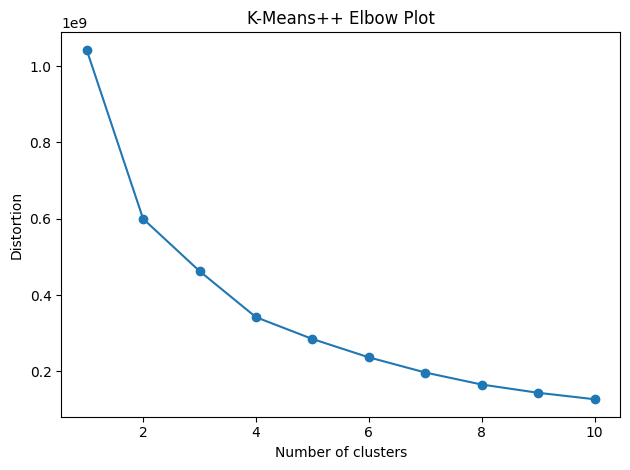

In [70]:
from sklearn.cluster import KMeans


# preprocessing_pipeline.fit(X_train)
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=0)
    km.fit(X_train)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Distortion")
plt.title("K-Means++ Elbow Plot")
plt.tight_layout()
plt.show()

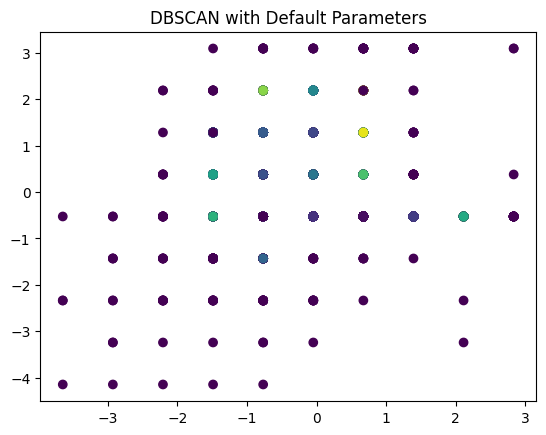

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# features = train[['Age', 'Fare', 'Pclass']]
# features['Age'].fillna(value = round(train['Age'].mean()), inplace = True)

# features = features.dropna()

scaler = StandardScaler()
features = scaler.fit_transform(X_train)
# Apply DBSCAN
db = DBSCAN()
labels = db.fit_predict(features)

# Plot results (if reduced to 2D using PCA or similar)
plt.scatter(features[:, 0], features[:, 1], c=labels)
plt.title("DBSCAN with Default Parameters")
plt.show()